In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil, time, copy
from random import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models, utils
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, random_split

from PIL import Image

from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score

In [2]:
# Dataset dir
data_dir = 'Monkeypox Skin Image Dataset/'
train_dir = 'Monkeypox Skin Image Dataset/train'
val_dir = 'Monkeypox Skin Image Dataset/val'

# Split 7:3
split_ratio = 0.7 

In [ ]:
# Split data train dan validation
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        shuffle(images)

        split_index = int(split_ratio * len(images))

        train_images = images[:split_index]
        val_images = images[split_index:]

        train_class_dir = os.path.join(train_dir, class_folder)
        val_class_dir = os.path.join(val_dir, class_folder)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for image in train_images:
            src_path = os.path.join(class_path, image)
            dest_path = os.path.join(train_class_dir, image)
            shutil.copy(src_path, dest_path)

        for image in val_images:
            src_path = os.path.join(class_path, image)
            dest_path = os.path.join(val_class_dir, image)
            shutil.copy(src_path, dest_path)

print("Dataset split and saved successfully.")

In [3]:
# Dataset transform dan augmentation
transform = {
    'train':transforms.Compose([
        transforms.Resize(232,interpolation=InterpolationMode.BILINEAR),
        transforms.RandomResizedCrop(232),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(232,interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

dataset = {x: datasets.ImageFolder(root=os.path.join(data_dir,x), transform=transform[x])
            for x in ['train', 'val']}

# Batching data loader
batch_size = 60
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size= batch_size, shuffle=True)
              for x in ['train', 'val']}
dataset_size = {x: len(dataset[x]) for x in ['train', 'val']}
class_names = dataset['train'].classes
num_classes = len(dataset['train'].classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Num Classes", num_classes)
print("Class names:", class_names)
num = {x:print(f"{x} data {dataset_size[x]}") for x in ['train','val']}

Num Classes 4
Class names: ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
train data 537
val data 233


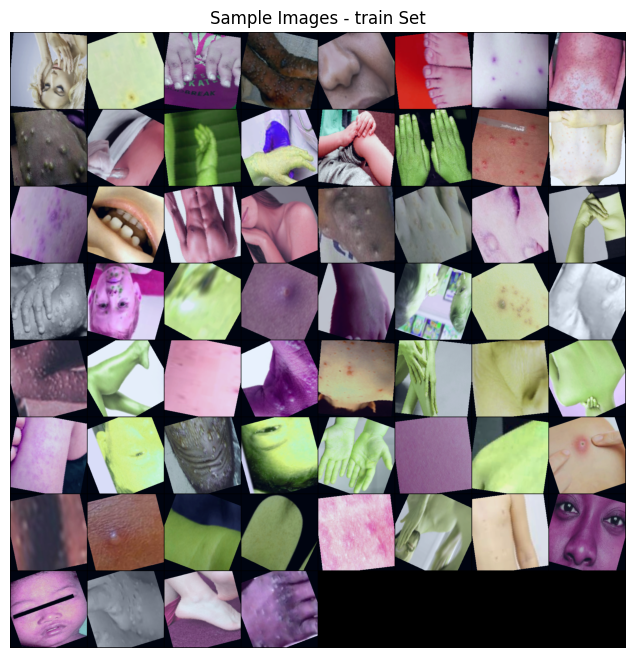

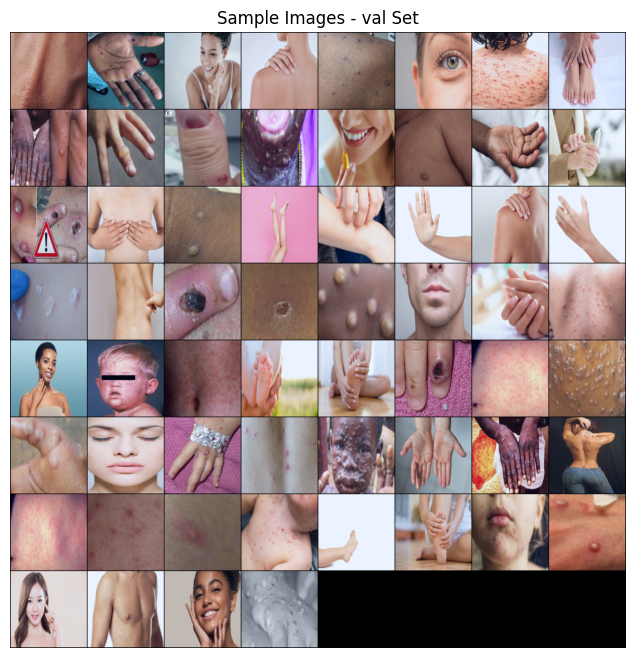

In [4]:
# Sample dataset
def show_images(data_loader, title):
    # Load data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Buat grid
    img_grid = utils.make_grid(images, nrow=8, padding=2, normalize=True)

    # Buat array
    img_np = np.transpose(img_grid.numpy(), (1, 2, 0))

    # Tampilkan grid
    plt.figure(figsize=(15, 8))
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')
    plt.savefig(title+'.png')
    plt.show()
    
show = {show_images(dataloaders[x], title=f'Sample Images - {x} Set') for x in ['train','val']}

In [5]:
def train_model(model, criterion, optimizer, scheduler, batch_size, num_epochs):
    since = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    valid_acc= list()
    train_loss= list()
    val_loss= list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Setiap epoch diuji train val
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch!=0:
                    scheduler.step()
                model.train()  # Set model ke mode train
            else:
                model.eval()   # Set model ke mode evaluate

            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterasi data
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # set zero gradient parameter
                optimizer.zero_grad()

                # forward
                # optimasi model fase train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistik
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_size
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]
            if phase=='train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch+1) )

    # load bobot terbaik
    model.load_state_dict(best_model)
    return model, train_acc, valid_acc, train_loss, val_loss

In [6]:
# Load model dengan bobot awal bawaan
model = models.resnet50(weights='DEFAULT')

# Sesuaikan input 4 class
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# LR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Gunakan GPU processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Jumlah epoch
num_epochs = 1000

model, train_acc, valid_acc, train_loss, val_loss=train_model(model, criterion, optimizer, scheduler, batch_size, num_epochs)

Epoch 1/1000
----------

preds: tensor([3, 0, 3, 0, 0, 3, 3, 0, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 1, 2, 3,
        3, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3,
        2, 1, 3, 3, 2, 3, 3, 3, 0, 3, 0, 3], device='cuda:0')
label: tensor([2, 2, 0, 2, 3, 2, 0, 2, 2, 3, 2, 3, 1, 1, 3, 0, 3, 0, 2, 3, 1, 3, 2, 3,
        1, 2, 0, 2, 1, 2, 1, 3, 3, 3, 2, 1, 2, 2, 3, 2, 2, 3, 0, 3, 2, 2, 0, 2,
        2, 1, 3, 2, 2, 3, 3, 0, 3, 2, 2, 3], device='cuda:0')
1-th epoch, 1-th batch (size=60), train acc= 0.350 


preds: tensor([3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2], device='cuda:0')
label: tensor([3, 0, 3, 3, 3, 2, 3, 3, 2, 1, 2, 2, 3, 2, 0, 3, 3, 3, 2, 2, 0, 2, 0, 2,
        2, 3, 2, 0, 2, 3, 0, 3, 3, 1, 1, 2, 3, 0, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2,
        0, 2, 3, 0, 3, 3, 3, 2, 3, 2, 2, 2], device='cuda:0')
1-th 

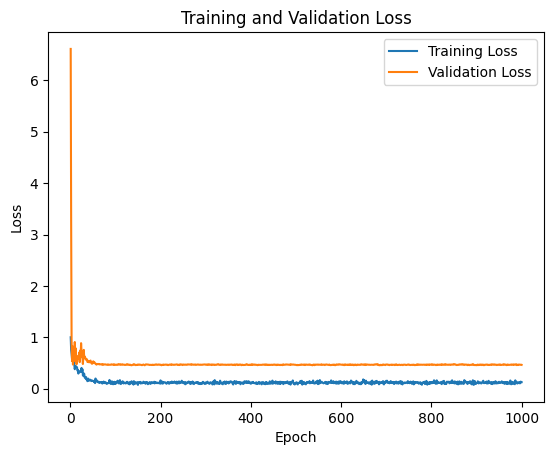

In [15]:
# Plot Loss
plt.plot(range(1, int(num_epochs) + 1), train_loss, label='Training Loss')
plt.plot(range(1, int(num_epochs) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('train-val-loss.png')
plt.show()

In [16]:
# Pindah cpu processing
train_acc = [acc.cpu() for acc in train_acc]
valid_acc = [acc.cpu() for acc in valid_acc]

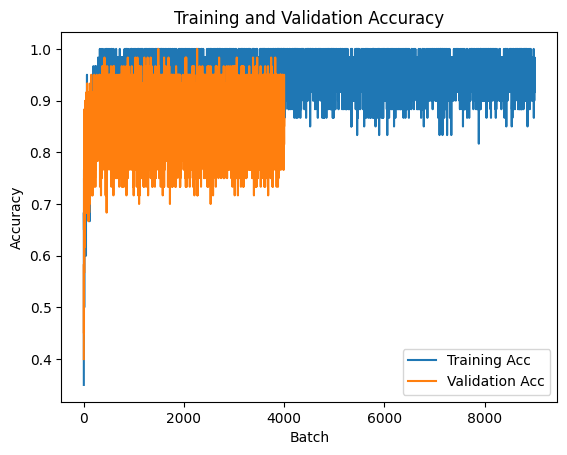

In [17]:
# Plot Acc
plt.plot(range(1, int(len(train_acc)) + 1), train_acc, label='Training Acc')
plt.plot(range(1, int(len(valid_acc)) + 1), valid_acc, label='Validation Acc')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('train-val-acc')
plt.show()

In [8]:
# Validasi model
all_predictions = []
all_labels = []
model.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print or log the metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9055793991416309
Recall: 0.9055793991416309
F1 Score: 0.9055391271587003


In [9]:
torch.save(model, 'training.pth')

In [10]:
print(f"Model Size: {sum(p.numel() for p in model.parameters())}")

Model Size: 23516228


In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [13]:
print(list(model.conv1.weight))

[tensor([[[-1.0670e-02,  1.1852e-03,  4.4819e-02, -5.5869e-02,  5.7032e-02,
          -7.6655e-03,  2.6463e-02],
         [-6.1933e-02,  4.8176e-02,  8.3924e-02, -1.6919e-01,  9.7115e-02,
           3.8754e-02, -4.5900e-02],
         [ 6.3927e-02, -2.6901e-01,  4.1122e-01, -1.2154e-01, -1.5256e-01,
           2.3370e-01, -5.5808e-02],
         [ 2.7001e-02,  1.3798e-01, -6.5189e-01,  1.1842e+00, -9.0764e-01,
           3.0318e-01, -2.0204e-02],
         [-1.0134e-01,  3.9352e-01, -4.3954e-01, -8.6650e-02,  7.0071e-01,
          -5.6523e-01,  2.3925e-01],
         [ 3.4941e-02, -1.6538e-01,  6.5807e-01, -8.9560e-01,  5.4171e-01,
          -3.8981e-02, -5.7430e-02],
         [ 5.7489e-02, -1.1512e-01,  3.4633e-02,  2.6977e-01, -3.4267e-01,
           1.9884e-01, -1.3208e-02]],

        [[ 2.1876e-03,  2.2155e-03, -1.6132e-02, -2.8273e-02,  8.8287e-02,
          -6.0983e-02,  2.8592e-02],
         [-4.4135e-02,  3.2619e-02,  8.3365e-02, -1.8449e-01,  1.1604e-01,
           2.1413e-02, -3.